#### Script homework2

Analysis and manipulation of the dataset MNIST (hand written digits)

#### Structure of the dataset
The dataset is made of a matrix with 42000 rows x 785 columns . 
Every row represent an observation, the first element represent the label (the corresponding digit).
the others 784 elements are a row matrix 28x28 with the image. 

In [63]:
#Methods ----
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy.sparse.linalg as spla
def plot_img(img, reshape_dim=None, cmap='gray'):
    '''
    Takes a np array and plot it using matplotlib 

    -x is the array
    -reshape could be either the dimension or None if the array is already reshaped
    Return None
    '''
    if reshape_dim !=None:
        img = np.reshape(img, reshape_dim)
    plt.imshow(img, cmap='gray')
    plt.show()

def divide_dataset(X, Y, N_train):
    '''
    Divide images and labels in train and test test.

    It uses N_train as threshold
    '''
    
    idxs = np.arange(0, len(X[0])-1, 1)
    np.random.shuffle(idxs)

    trian_idxs = idxs[:N_train]
    test_idxs = idxs[N_train:]


    XTrain = X[:,trian_idxs]
    YTrain = Y[trian_idxs]

    XTest = X[:,test_idxs]
    YTest = Y[test_idxs]

    return (XTrain, YTrain), (XTest, YTest)

def cluster_centroid(Z, Y, label):
    '''
    Z is the reduced dataset
    Y is the labels array
    label is the class of the cluster
    '''
    return np.mean(Z[:, Y==label], axis = 1 )

def PCA(X, Y, k, classes, reduced = True, plot = True):
    '''
    -X is the dataset
    -k is the dimension of the reduction
    -reduced -- True 
             -- False
             Compute also a reduced SVD image 
    Return a reduced dataset and eventually a reduced SVD of images.

    Method
    1- Computation of the centroid
    2- Compute Xcentred
    3- Compute the SVD
    4- Compute the reduced SVD given K if asked
    5- Compute the projected dataset of shape k, len(X[0])
    '''
    centr = np.mean(X, axis = 1)
    XCentred = X - centr.reshape((len(centr), 1))

    U, s, VT = np.linalg.svd(XCentred, full_matrices=False)
    
    if reduced :
        reducedMatrix = 0
    
        for i in range(k):
            # single column matrix
            Vtemp = np.reshape(VT[i, :], (1, len(VT[0])))
            Utemp = np.reshape(U[:, i], (len(U[:, i]), 1))
            SingleMatrix =  Utemp @ Vtemp * s[i]
            reducedMatrix += SingleMatrix
    else:
        reducedMatrix = None
    Z = U[:,:k].T @ XCentred
    if plot and k == 2:
        fig, ax = plt.subplots()
        sc = plt.scatter(Z[0, :], Z[1, :], c=Y, s=10)
        leg = plt.legend(*sc.legend_elements(), title = 'Classes')
        ax.add_artist(leg)
        plt.title('PCA scomposition')
        plt.show()
    return  Z, reducedMatrix, U[:,:k]

def LDA(X, Y, classes, k, plot=True):
    '''
    -X is the dataset    
    -Y is the vector with corresponding labels
    -classes is an iterable with the name of the labels in Y
    -k is the dimension of the reduction
    -plot let plot the Reduced dataset computed using LDA
    

    Return the reduced version of the dataset of shape k, len(X[0])

    Method:
     -- Compute the global centroid and the centroid for each class,
        which are related to axis = 1 (pixels mean).
     -- Compute the within-cluster scatter matrix Sw, which represents the correlation
        of points in each cluster
     -- Compute the between-cluster scatter matrix Sb, which represents the correlation 
        between points in different clusters
     -- Compute a projector such that the Sw is maximised and Sb is minimised,
        (Through Cholesky factorization)

     -- Project X on Z  
        
    '''
    
    C_glob = X.mean(axis = 1)
    centroids = [X[:, (Y == value)].mean(axis = 1) for value in classes] #Compute a list of centroid class for class

    xlist = [X[:, (Y==values)] for values in classes]
    
    xcentredlist = []
    for i in range(len(xlist)):
        Xcc = xlist[i] - centroids[i].reshape(len(centroids[i]), 1)
        xcentredlist.append(Xcc)
    Xw = np.concatenate(xcentredlist, axis = 1)
    
    Sw = Xw @ Xw.T


    # Scatter matrix creation
    centr_matrix_list = []
    for i, centroid in enumerate(centroids):
        matrix = np.repeat(centroid.reshape(len(centroid), 1), len(xlist[i]), axis = 1)
        centr_matrix_list.append(matrix)
    C = np.concatenate(centr_matrix_list, axis = 1)
    Ccentred = C - C_glob.reshape(len(C_glob), 1)

    Sb = Ccentred @ Ccentred.T 
    
    # Cholesky
    try:
        L = np.linalg.cholesky(Sw)
    except:
        epsilon = 1e-6
        identity = epsilon* np.eye(Sw.shape[0])
        Sw += identity
        L = np.linalg.cholesky(Sw)
    
    P = np.linalg.inv(L) @ Sb @ L



    _, eigv = spla.eigs(P, k)

    Q = np.linalg.inv(L).T @ np.real(eigv)


    Z = Q.T @ X
    if plot and k == 2:
        fig, ax = plt.subplots()
        sc = plt.scatter(Z[0, :], Z[1, :], c=Y, s=10)
        leg = plt.legend(*sc.legend_elements(), title = 'Classes')
        ax.add_artist(leg)
        plt.title('LDA scomposition')
        plt.show()
    return Z, Q



def average_distance(Z, Y, label, centroid):
    '''
    -Z is the reduced dataset
    -Y is the labels array
    -label is the class of the cluster
    '''
    centr_arr = np.array(centroid).reshape(len(centroid), 1)
    
    arr = np.mean(Z[:, Y==label] - centr_arr, axis = 1)
   
    return np.sqrt(np.linalg.norm(arr))


def classification_algorithm(obs, centroids, gt):
    '''
    - obs is an observation of the reduced dataset
    - classes are all the possbile groundtruths of the dataset 
    - centroids is the list of cluster-centroids 
    - gt is the class of obs
    '''
    dict_distances = { average_distance(obs, 1, 1, key) : centroids[key] for key in centroids}

    idx_min = min(dict_distances.keys())

    predicted_class = dict_distances[idx_min]  

    return predicted_class == gt

def accuracy(X, centr_dicts, Y):
    results = [classification_algorithm(X[:, i], centr_dicts, gt) for i, gt in enumerate(Y)]

    correct_pred = np.sum(results)

    correctness = correct_pred / len(Y)
    print('Percentage of correct classifications : {}'.format(correctness))
    return correctness



#### 1) Loading data 


In [24]:
import numpy as np
import pandas as pd

data = pd.read_csv('data.csv')

print(data.head)

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pi

#### 2, 3) Separation of dataset and labels, digits selection.

In [25]:
#Lets divide the labels array from the images
data = np.array(data).T

X = data[1:, :]
Y = data[0, :]

print('Dataset shape : {}\nLabels array shape : {}'.format(X.shape, Y.shape))

# Choose the digits
classes = (1, 6, 9) 

# I apply my mask to the two arrays
masks = [Y == i for i in classes]

Xlist = [X[:, mask] for mask in masks]

Ylist = [Y[mask] for mask in masks]

print('Single class datasets shape')
print([X.shape for X in Xlist])

X = np.concatenate(Xlist, axis=1) 
Y = np.concatenate(Ylist)

print('Dataset with only selected digits')
print('X : {}\nY : {} '.format(X.shape, Y.shape))

Dataset shape : (784, 42000)
Labels array shape : (42000,)
Single class datasets shape
[(784, 4684), (784, 4137), (784, 4188)]
Dataset with only selected digits
X : (784, 13009)
Y : (13009,) 


#### 4) Dataset splitting into train and test

Train set shape : (784, 10407)
Test set shape : (784, 2601)


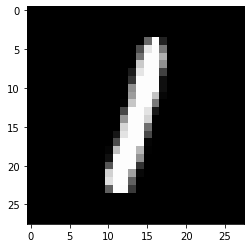

Label : 1


In [68]:
(Xtrain, Ytrain), (Xtest, Ytest) = divide_dataset(X, Y, int(0.8 * len(X[0])))

print('Train set shape : {}'.format(Xtrain.shape))
print('Test set shape : {}'.format(Xtest.shape))
plot_img(Xtrain[:, 0], (28,28))
print('Label : {}'.format(Ytrain[0]))

#### 5) PCA and LDA

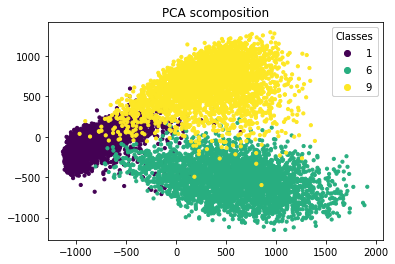

Values of the PCA centroids : {(-797.3307192855737, -93.95309727473449): 1, (584.209345714333, -531.2986938732483): 6, (318.63217559113025, 637.5040063179306): 9}
Values of the average distances from the centroid : [1.12294743177591e-06, 1.28285329241281e-06, 3.557406162691292e-07]


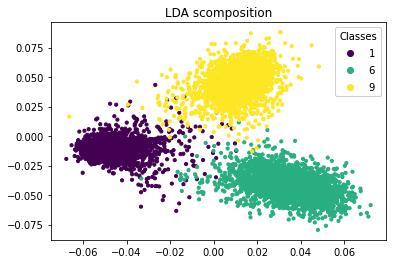

Values od the LDA centroids : {(-0.04619831984143029, -0.011508548327570796): 1, (0.03562661814141603, -0.04277115318999219): 6, (0.012422391861280972, 0.04702619553303917): 9}
Values of the average distances from the centroid : [4.270206272273698e-09, 2.194842820780357e-09, 4.9927823468367634e-09]


In [75]:
# Reordering of the Train set

Xtrain = np.concatenate([Xtrain[:, Ytrain == digit] for digit in classes], axis = 1)
Ytrain = np.concatenate([Ytrain[Ytrain == digit] for digit in classes])

Z_pca, _, Projector_PCA = PCA(Xtrain, Ytrain, 2, classes)

centroids_pca = {tuple(cluster_centroid(Z_pca, Ytrain, label)) : label for label in classes}
print('Values of the PCA centroids : {}'.format(centroids_pca))

avg_dist = [average_distance(Z_pca, Ytrain, centroids_pca[key], key) for key in centroids_pca]

print('Values of the average distances from the centroid : {}'. format(avg_dist))

Z_lda, Projector_LDA = LDA(Xtrain, Ytrain, classes, k = 2)

centroids_lda = {tuple(cluster_centroid(Z_lda, Ytrain, label)) : label for label in classes}
avg_dist_lda = [average_distance(Z_lda, Ytrain, centroids_lda[key], key) for key in centroids_lda]

print('Values od the LDA centroids : {}'.format(centroids_lda))
print('Values of the average distances from the centroid : {}'. format(avg_dist_lda))

#### 6) PCA and LDA applied to test set

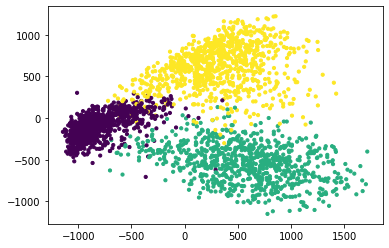

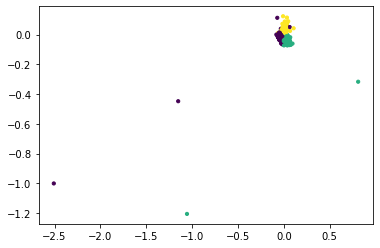

In [76]:

Xtest_pca =  Projector_PCA.T @ (Xtest - np.reshape(np.mean(Xtest, axis = 1), (len(np.mean(Xtest, axis = 1)), 1)))

Xtest_lda = Projector_LDA.T @ Xtest

#avg_dist_pca = [average_distance(Xtest_pca, Ytest, label, centroids_pca[i]) for i, label in enumerate(classes)] 
#avg_dist_lda = [average_distance(Xtest_lda, Ytest, label, centroids_lda[i]) for i, label in enumerate(classes)]

#print('Values of the average distances from the centroid PCA : {}'. format(avg_dist_pca))
#print('Values of the average distances from the centroid LDA : {}'. format(avg_dist_lda))


plt.scatter(Xtest_pca[0, :], Xtest_pca[1, :], c=Ytest, s=10)
plt.show()
plt.scatter(Xtest_lda[0, :], Xtest_lda[1, :], c=Ytest, s=10)
plt.show()

#### 7) Classification 



In [85]:
print('PCA')
accuracy_pca = accuracy(Xtest_pca, centroids_pca, Ytest)

print('LDA')
accuracy_lda = accuracy(Xtest_lda, centroids_lda, Ytest) 



# Lets now change the value of k
Zpca , _, new_Projector_PCA = PCA(Xtrain, Ytrain, 10, classes)
Zlda, new_Projector_LDA = LDA(Xtrain, Ytrain, classes, 10)

Xtest_pca_new = new_Projector_PCA.T @ (Xtest - np.reshape(np.mean(Xtest, axis = 1), (len(np.mean(Xtest, axis = 1)), 1)))
centroids_pca_new = {tuple(cluster_centroid(Zpca, Ytrain, label)) : label for label in classes}
print(Xtest_pca.shape)
Xtest_lda_new = new_Projector_LDA.T @ Xtest
centroids_lda_new = {tuple(cluster_centroid(Zlda, Ytrain, label)) : label for label in classes}
print('PCA')
accuracy_pca = accuracy(Xtest_pca_new, centroids_pca_new, Ytest)

print('LDA')
accuracy_lda = accuracy(Xtest_lda_new, centroids_lda_new, Ytest)



PCA
Percentage of correct classifications : 0.9388696655132641
LDA
Percentage of correct classifications : 0.9900038446751249
(2, 2601)
PCA
Percentage of correct classifications : 0.9565551710880431
LDA
Percentage of correct classifications : 0.9900038446751249


#### 8) Visualizing dyad

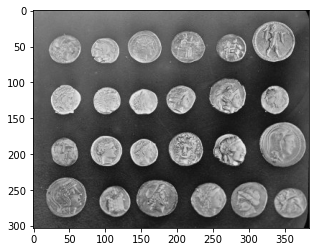

In [89]:
import skimage.data as skd
img = skd.coins()
plt.imshow(img, cmap = 'gray')
plt.show()

(303, 303) (384, 384)
(303,) (384,)


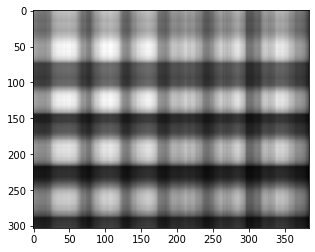

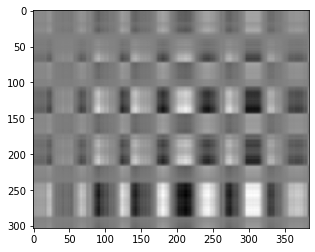

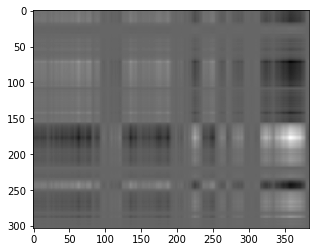

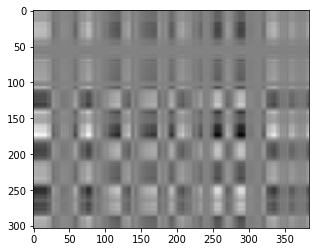

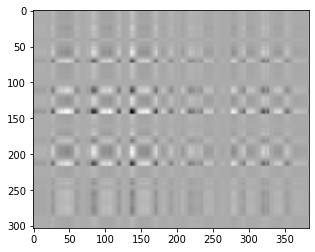

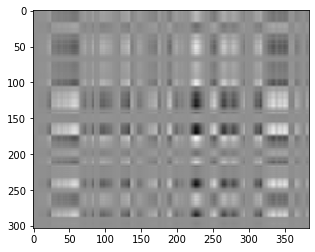

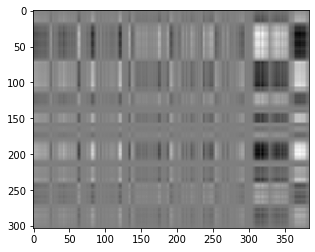

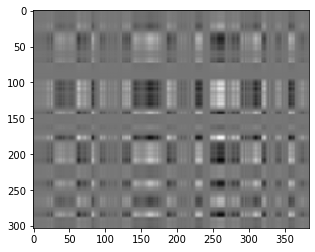

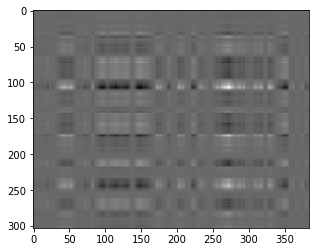

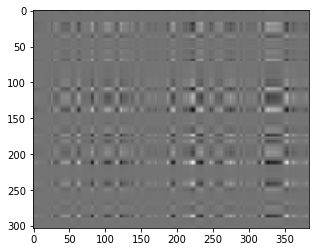

In [110]:
U, s , VT = np.linalg.svd(img, full_matrices=True)

print(U.shape, VT.shape)
print(U[:, 0].shape, VT[0, :].shape )

for i in range(10):
    Ui = U[:, i].reshape(len(U[0]), 1)
    VTi = VT[i, :].reshape(1, len(VT[0]))
    dyad = Ui @ VTi * s[i]
    plt.imshow(dyad, cmap='gray')
    plt.show()

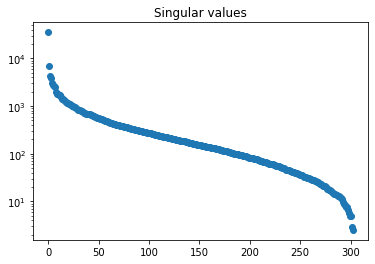

In [132]:
plt.plot(range(len(s)),s, 'o')
plt.title('Singular values')
plt.yscale('log')
plt.show()

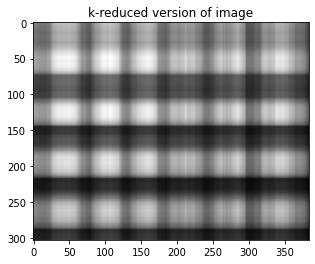

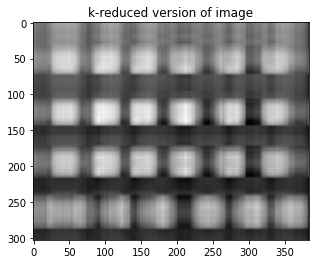

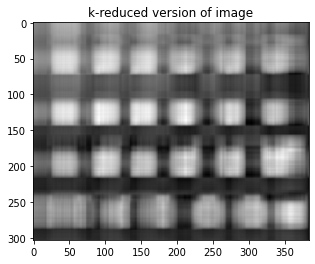

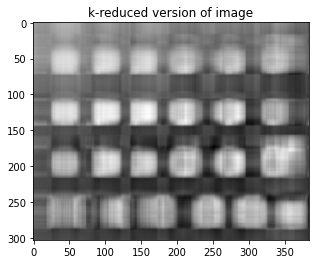

In [135]:
for k in range(1, 5):
    sum = np.zeros(img.shape)
    for i in range(k): 
        Ui = U[:, i].reshape(len(U[0]), 1)
        VTi = VT[i, :].reshape(1, len(VT[0])) 
        sum += Ui @ VTi * s[i]
    plt.imshow(sum, cmap='gray')
    plt.title('k-reduced version of image')
    plt.show()


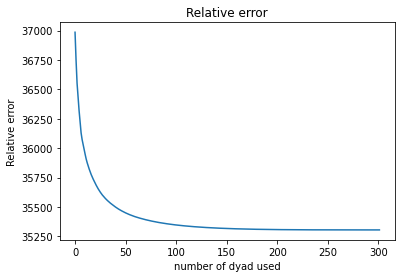

In [130]:
sum = np.zeros(img.shape)
errors = []
for i in range(1, len(s)):
    Ui = U[:, i].reshape(len(U[0]), 1)
    VTi = VT[i, :].reshape(1, len(VT[0])) 
    dyad = Ui @ VTi * s[i]
    sum += dyad
    rel_error = np.linalg.norm((img - sum))
    errors.append(rel_error)
plt.plot(range(len(errors)), errors)
plt.title("Relative error")
plt.xlabel('number of dyad used')
plt.ylabel('Relative error')
plt.show()

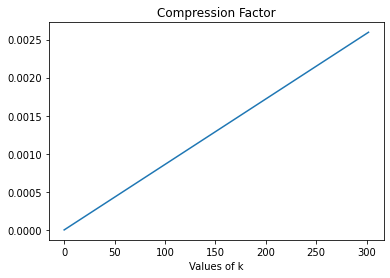

In [134]:
comp_factor_list = [k / (img.shape[0] * img.shape[1]) for k in range(len(s))]
plt.plot(range(len(s)), comp_factor_list)
plt.title('Compression Factor')
plt.xlabel('Values of k')
plt.show()